In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import itertools as itertools
from tools import * 

In [2]:
# importing data 
df = pd.read_excel('./data/Superstore.xls')

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
furniture = df[(df["Category"]=="Furniture")]
print (furniture["Order Date"].min(), furniture["Order Date"].max())

2014-01-06 00:00:00 2017-12-30 00:00:00


In [6]:
furniture.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,2121.0,5041.643564,2885.740258,1.0000,2568.000,5145.0000,7534.0000,9991.000
Postal Code,2121.0,55726.556341,32261.888225,1040.0000,22801.000,60505.0000,90032.0000,99301.000
Sales,2121.0,349.834887,503.179145,1.8920,47.040,182.2200,435.1680,4416.174
Quantity,2121.0,3.785007,2.251620,1.0000,2.000,3.0000,5.0000,14.000
Discount,2121.0,0.173923,0.181547,0.0000,0.000,0.2000,0.3000,0.700
Profit,2121.0,8.699327,136.049246,-1862.3124,-12.849,7.7748,33.7266,1013.127


In [7]:
# Removing columns that arent required/ wont be using this time
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']
furniture = furniture.drop(cols,axis=1)
furniture.isnull().sum()

Order Date    0
Sales         0
Quantity      0
Discount      0
Profit        0
dtype: int64

In [8]:
furniture.columns

Index(['Order Date', 'Sales', 'Quantity', 'Discount', 'Profit'], dtype='object')

In [9]:
furniture = furniture.set_index('Order Date').sort_index()

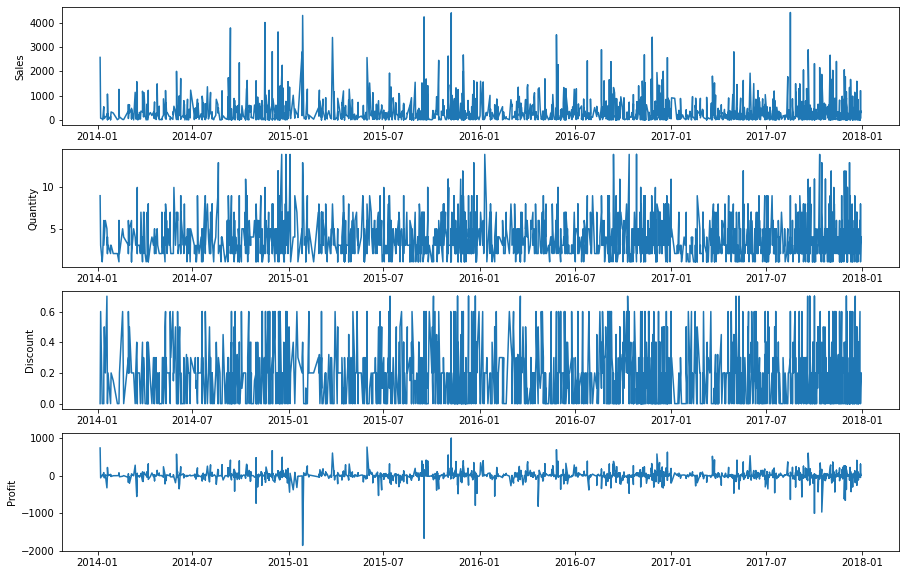

In [10]:
cols = furniture.columns
plt.figure(figsize=(15,10))
for i in range(0,len(cols)):
    plt.subplot(len(cols),1,i+1)
    plt.plot(furniture[cols[i]])
    plt.ylabel(cols[i])

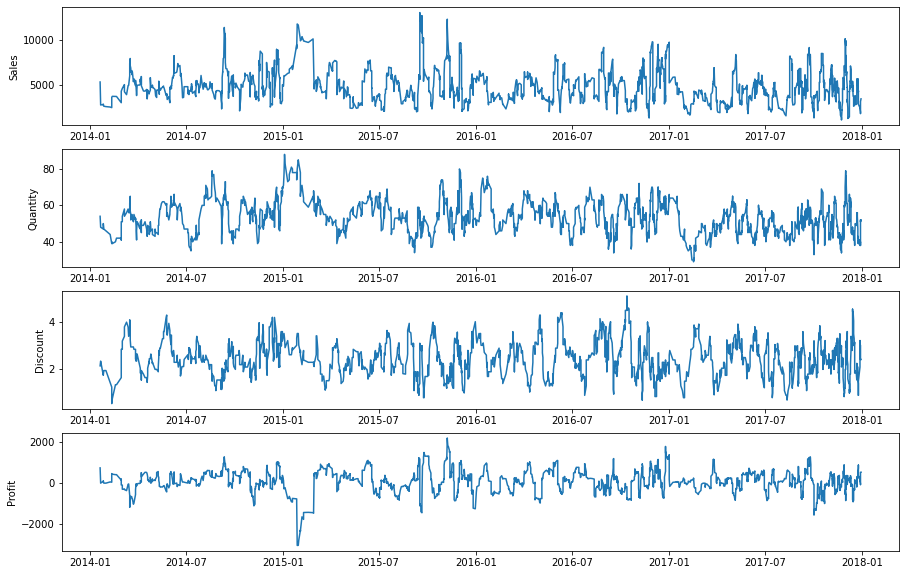

In [11]:
test = furniture.rolling(14).sum()
cols = furniture.columns
plt.figure(figsize=(15,10))
for i in range(0,len(cols)):
    plt.subplot(len(cols),1,i+1)
    plt.plot(test[cols[i]])
    plt.ylabel(cols[i])

In [12]:
# Using average daily sales per month instead of the daily sales 
furniture_monthly = furniture.resample('W').mean()
#Appling a 2 week smoothing filter over the data in order to keep all datapoints
furniture["Order Date"] = furniture.index
furniture = furniture.drop_duplicates(subset='Order Date')
furniture = furniture.drop('Order Date',axis=1)
furniture = furniture.asfreq('1D').interpolate(method='slinear')
furniture_smooth = furniture.ewm(span=7).mean()
furniture_smooth = furniture_smooth.sort_index()

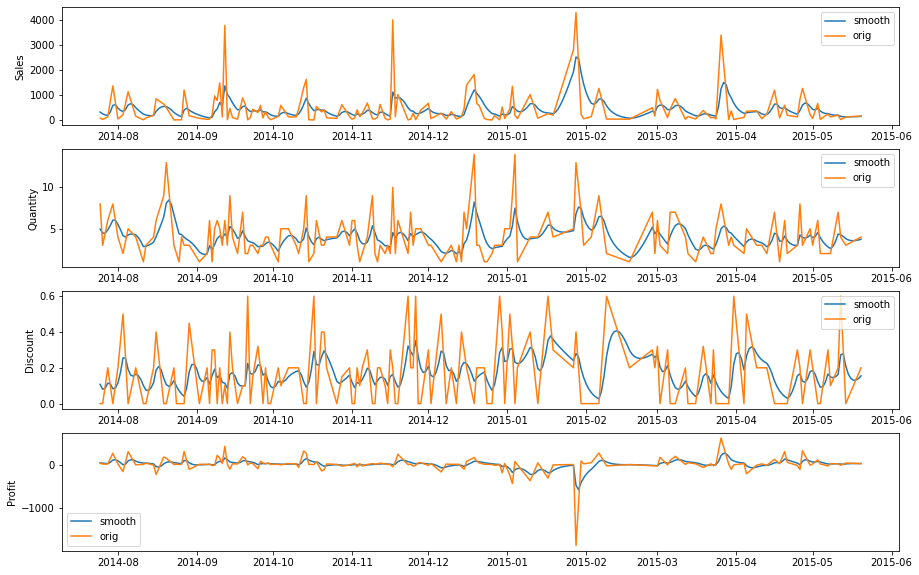

In [13]:
cols = furniture.columns
plt.figure(figsize=(15,10))
for i in range(0,len(cols)):
    plt.subplot(len(cols),1,i+1)
    plt.plot(furniture_smooth[cols[i]][200:500],label='smooth')
    plt.plot(furniture[cols[i]][200:500],label='orig')
    plt.legend()
    plt.ylabel(cols[i])

In [14]:
def split_dataset(data,split=0.8):
    """
    Splits time series dataset into a training set and a test set
    Inputs:   
        data = numpy array of data
        split = float between 0-1 for the test split amount. 
    Outputs: 
        train, test sets
    """
    train = data[0:round(len(data)*split)]
    test = data[round(len(data)*(split))-1::]
    print ("%s timesteps in training set" %(len(train)))
    print ("%s timesteps in test set" %(len(test)))
    return train, test

In [15]:
def evaluate_forecasts(actual, predicted):
    """
    Evaluates the forecasts of a time series prediction. 
    inputs: 
        Actual and predicted numpy arrays 
    Outputs: 
        RMSE : RMSE of each prediction 
        score : average RMSE value
    """
    mse = (actual-predicted)**2
    rmse= np.sqrt(mse)
    score = np.sqrt((np.sum(mse)/len(actual)))
    return rmse, score

In [57]:
def plot_results(actual, pred, std=0):
    """
    Plot results of a time series prediction showing standard deviation of predictions (if a number of predictions were run to get probability )

    Inputs: 
        actual: array or dataframe of actual test values 
        pred : predictions 
        std : standard deviation of each prediction step
    """

    ind = actual.index
    mean_res = np.mean(abs((actual-pred)))

    plt.figure(figsize=(20,15))
    plt.subplot(3,1,1)
    plt.plot(actual,'o-')
    plt.plot(ind,pred,'o-',label="Mean Predictions")
    plt.plot(ind,pred-std,'g--',label="1 Standard deviation")
    plt.plot(ind,pred+std,'g--')
    plt.ylabel("Sales")
    plt.title("Sales Predictions")
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(ind,std,'bo-',label='Standard Deviation of predictions.')
    plt.title("Standard Deviation of Predictions. Mean = %.2f"%np.mean(std))
    plt.subplot(3,1,3)
    plt.plot(ind,actual-pred,marker='o',label='Residual')
    plt.ylabel("Residual")
    plt.title('Mean Residual = %.2f'%mean_res)

In [17]:
# Moving to deep learning techniques: 
# LSTM 
# Autoencoder LSTM 
# Conv LSTM? 

In [18]:
def window_split(data, y_col,wind_len=14, pred_len=7,validate_set=False,validate_perc=0.2):
    """
    Splits datasets ready for training in a NN.

    Inputs: 
        data : numpy array or dataframe (single column) of your data
        wind_len : how many timesteps you want to use to predict the future steps 
        pred_len : how many timesteps you want to predict
        validate_set : boolean of whether you want a validation set from your test set
        validation_perc = float of what % of your test set you want to be validation set

    Output: 
        X, y, X_val, y_val to be input into LSTM/RNN
    """
    # numpy data
    if len(data.shape)==1:
        data_y = np.copy(data)
        data = data.values.reshape(data.values.shape[0],1)
    else: 
        data_y = data[y_col].values
        data = data.values
    # inputs to supervised learning
    X, y = [], []
    # start of window 
    wind_start = 0 
    for i in range(0,len(data)):
        wind_end= wind_start+wind_len 
        pred_end = wind_end+pred_len
        if pred_end<=len(data):
            X.append(data[wind_start:wind_end].reshape((wind_len,data.shape[1])))
            y.append(data_y[wind_end:pred_end])
        # move along timestep
        wind_start+=1
    X = np.array(X)
    y = np.array(y)
    if validate_set:
        num = int(np.round(len(X)*(1-validate_perc)))
        X_val, y_val, X, y = X[num::,:,:], y[num::,:], X[0:num,:,:] ,y[0:num,:]
        print ("X shape: %s"%str(X.shape))
        print ("y shape: %s"%str(y.shape))
        print ("X_val shape: %s"%str(X_val.shape))
        print ("y_val shape: %s"%str(y_val.shape))
        return X,y,X_val,y_val
    
    print ("X shape: %s"%str((X.shape)))
    print ("y shape: %s"%str((y.shape)))
    return X,y

In [28]:
def build_model(data,m,fit=True,callback=False,wind_len=7,pred_len=7,batch=16,epoch=200,val=False,val_perc=0.2,plot=False,verbose=1):

    """
    Takes your data, builds a model, fits the model and outputs model and history. 

    Inputs: 
        data : numpy array or dataframe (single column) of your data
        m   : string of possible models ; "LSTM", "Stacked_LSTM", "Enc_Dec_LSTM"
        fit : boolean, do you want to fit model? 
    """
    # window split train data
    if val: 
        train_x, train_y, val_x, val_y = window_split(data,y_col="Sales",wind_len=wind_len,pred_len=pred_len,validate_set=val)
    else:
        train_x, train_y = window_split(data,wind_len=wind_len,pred_len=pred_len,validate_set=val)
    # building model
    model = Sequential()
    if m == "LSTM":
        model.add(LSTM(300,activation='relu',input_shape=((train_x.shape[1], train_x.shape[2]))))
        model.add(Dropout(0.4))
        model.add(Dense(200,activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(pred_len))

    elif m =="Stacked_LSTM":
        model.add(LSTM(200,activation='relu',return_sequences=True,input_shape=((train_x.shape[1], train_x.shape[2]))))
        model.add(LSTM(200,activation='relu',return_sequences=True))
        model.add(LSTM(200,activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(200,activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(pred_len))

    elif m=="EncDec_LSTM":
        # Encoder layer
        model.add(LSTM(200,activation='relu',input_shape=((train_x.shape[1], train_x.shape[2]))))
        model.add(Dropout(0.5))
        # Repeating the encoded vector of fixed length for the decoder layer. Needs to repeat equal to the number of output prediction samples
        model.add(RepeatVector(pred_len))
        # Decoder layer
        model.add(LSTM(200,activation='relu',return_sequences=True))
        model.add(Dropout(0.5))
        # Time distributed dense layers
        model.add(TimeDistributed(Dense(100,activation='relu')))
        model.add(Dropout(0.5))
        model.add(TimeDistributed(Dense(1)))

    opt = Adam(0.001)
    model.compile(loss='mse',optimizer=opt)

    history = []
    # Fitting model
    if fit:
        if val:
            if callback:
                cb = EarlyStopping( monitor='val_loss', min_delta=5000, patience=100, verbose=0,
                                    mode='min', restore_best_weights=True)
                history = model.fit(train_x,train_y,epochs=epoch,validation_data=(val_x,val_y),callbacks=cb,verbose=verbose)
            else: 
                history = model.fit(train_x,train_y,epochs=epoch,validation_data=(val_x,val_y),verbose=verbose)
        else: 
            history = model.fit(train_x,train_y,epochs=epoch,verbose=verbose)

    history = pd.DataFrame(history.history)

    if plot: 
        history.plot()

    return model,history

In [29]:
train, test = split_dataset(furniture_smooth)

1164 timesteps in training set
292 timesteps in test set


In [30]:
def forecast(model, data,data2=train["Sales"], wind_len=14, pred_len=7):

    """ 
    model = trained model 
    data = training data 
    """
    # Extracting last window length to be used to predict
    prev = data2[-wind_len:].values.reshape(1,wind_len,1)
    # Calculating number of weeks to predict
    num_pred_weeks = int(np.ceil(len(data)/pred_len))
    # Reshaping history to be appended in the loop
    history=prev.reshape(wind_len)
    # empty list to fill in loop
    predictions = []
    for i in range(num_pred_weeks):
    # for i in range(5):
        predictions.append(model.predict(prev))
        if (i+1)*pred_len>len(data):
            pred_len=abs(len(data)-(i+1)*pred_len)
        history=np.append(history,data[i*pred_len+1:(i+1)*pred_len+1].values.reshape(pred_len))
        prev = history[-(wind_len):].reshape(1,wind_len,1)


    # Extracting predictions 
    predictions = np.array(predictions).flatten()[0:len(test)]
        
    return predictions    


In [31]:
def average_preds(preds):
    mean_pred = np.mean(preds,axis=0)
    std = np.std(preds,axis=0)
    return mean_pred, std

In [24]:
epoch = 600
wind_len =14
pred_len =7
batch = 64

In [32]:

# Running the training and prediction a number of times to generate probabilities 
num_runs=10
LSTM_predictions = []
scores = []
rmses = []
for run in range(0,num_runs): 
    m = "LSTM"
    # Bulding and fitting model 
    print ("Beginning Training round: %s" %(run+1))
    LSTM_model, history = build_model(  train["Sales"],m=m,wind_len=wind_len,pred_len=pred_len,
                                        fit=True,batch=batch,epoch=epoch,val=True,plot=False,
                                        callback=True,verbose=0)
    print ("Finished round: %s" %(run+1))
    # Saving losses through training 
    history["model"]=m
    hists=history
    # Predicting
    LSTM_predictions.append(forecast(LSTM_model,data=test["Sales"]))
    # Evaluating predictions
    rmse,score = evaluate_forecasts(test["Sales"],LSTM_predictions[run])
    scores.append(score)
    rmses.append(rmse)
    print ("Training round %s RMSE = %.2f" %((run+1),score))

LSTM_scores = {}
LSTM_scores[m]=scores

Beginning Training round: 1
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 1
Training round 1 RMSE = 165.64
Beginning Training round: 2
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 2
Training round 2 RMSE = 175.38
Beginning Training round: 3
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 3
Training round 3 RMSE = 173.70
Beginning Training round: 4
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 4
Training round 4 RMSE = 164.95
Beginning Training round: 5
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 5
Training round 5 RMSE = 164.19
Beginning Training round: 6
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 6
Training round 6 RMSE = 156.34
Beginning 

In [37]:
# Running the training and prediction a number of times to generate probabilities 
num_runs=10
Stacked_LSTM_predictions = []
scores = []
rmses = []
for run in range(0,num_runs): 
    m = "Stacked_LSTM"
    # Bulding and fitting model 
    print ("Beginning Training round: %s" %(run+1))
    Stacked_LSTM_model, history = build_model(  train["Sales"],m=m,wind_len=wind_len,pred_len=pred_len,
                                        fit=True,batch=batch,epoch=epoch,val=True,plot=False,
                                        callback=True,verbose=0)
    print ("Finished round: %s" %(run+1))
    # Saving losses through training 
    history["model"]=m
    hists=history
    # Predicting
    Stacked_LSTM_predictions.append(forecast(Stacked_LSTM_model,data=test["Sales"]))
    # Evaluating predictions
    rmse,score = evaluate_forecasts(test["Sales"],Stacked_LSTM_predictions[run])
    scores.append(score)
    rmses.append(rmse)
    print ("Training round %s RMSE = %.2f" %((run+1),score))

LSTM_scores = {}
LSTM_scores[m]=scores

Beginning Training round: 1
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 1
Training round 1 RMSE = 183.67
Beginning Training round: 2
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 2
Training round 2 RMSE = 179.25
Beginning Training round: 3
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 3
Training round 3 RMSE = 184.11
Beginning Training round: 4
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 4
Training round 4 RMSE = 164.32
Beginning Training round: 5
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 5
Training round 5 RMSE = 180.58
Beginning Training round: 6
X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Finished round: 6
Training round 6 RMSE = 165.36
Beginning 

In [38]:

# # Running the training and prediction a number of times to generate probabilities 
# num_runs=10
# Multi_LSTM_predictions = []
# scores = []
# rmses = []
# # for run in range(0,num_runs): 
# m = "LSTM"
# # Bulding and fitting model 
# # print ("Beginning Training round: %s" %(run+1))
# Multi_LSTM_model, history = build_model(  train["Sales"],m=m,wind_len=wind_len,pred_len=pred_len,
#                                     fit=True,batch=batch,epoch=epoch,val=True,plot=False,
#                                     callback=True,verbose=1)
# # print ("Finished round: %s" %(run+1))
# # Saving losses through training
# m = "Uni_LSTM" 
# history["model"]=m
# hists=history
# # Predicting
# Multi_LSTM_predictions.append(forecast(Multi_LSTM_model,data=test["Sales"]))
# # Evaluating predictions
# rmse,score = evaluate_forecasts(test["Sales"],Multi_LSTM_predictions)
# scores.append(score)
# rmses.append(rmse)
# # print ("Training round %s RMSE = %.2f" %((run+1),score))

# LSTM_scores = {}
# LSTM_scores[m]=scores

X shape: (915, 14, 1)
y shape: (915, 7)
X_val shape: (229, 14, 1)
y_val shape: (229, 7)
Epoch 1/600
29/29 [==============================] - 1s 41ms/step - loss: 122520.9531 - val_loss: 34385.3047
Epoch 2/600
29/29 [==============================] - 1s 33ms/step - loss: 104292.5469 - val_loss: 39483.0312
Epoch 3/600
29/29 [==============================] - 1s 35ms/step - loss: 94485.4062 - val_loss: 34049.2930
Epoch 4/600
29/29 [==============================] - 1s 36ms/step - loss: 134060.2031 - val_loss: 32298.4551
Epoch 5/600
29/29 [==============================] - 1s 37ms/step - loss: 87833.7188 - val_loss: 44714.9141
Epoch 6/600
29/29 [==============================] - 1s 38ms/step - loss: 85813.4062 - val_loss: 35393.6953
Epoch 7/600
29/29 [==============================] - 1s 43ms/step - loss: 79531.4609 - val_loss: 29689.0566
Epoch 8/600
29/29 [==============================] - 1s 36ms/step - loss: 84638.5469 - val_loss: 30820.7148
Epoch 9/600
29/29 [==========================

ValueError: Length of passed values is 1, index implies 292.

In [42]:
LSTM_mean_pred, LSTM_std = average_preds(LSTM_predictions)
Stacked_LSTM_mean_pred, Stacked_LSTM_std = average_preds(Stacked_LSTM_predictions)

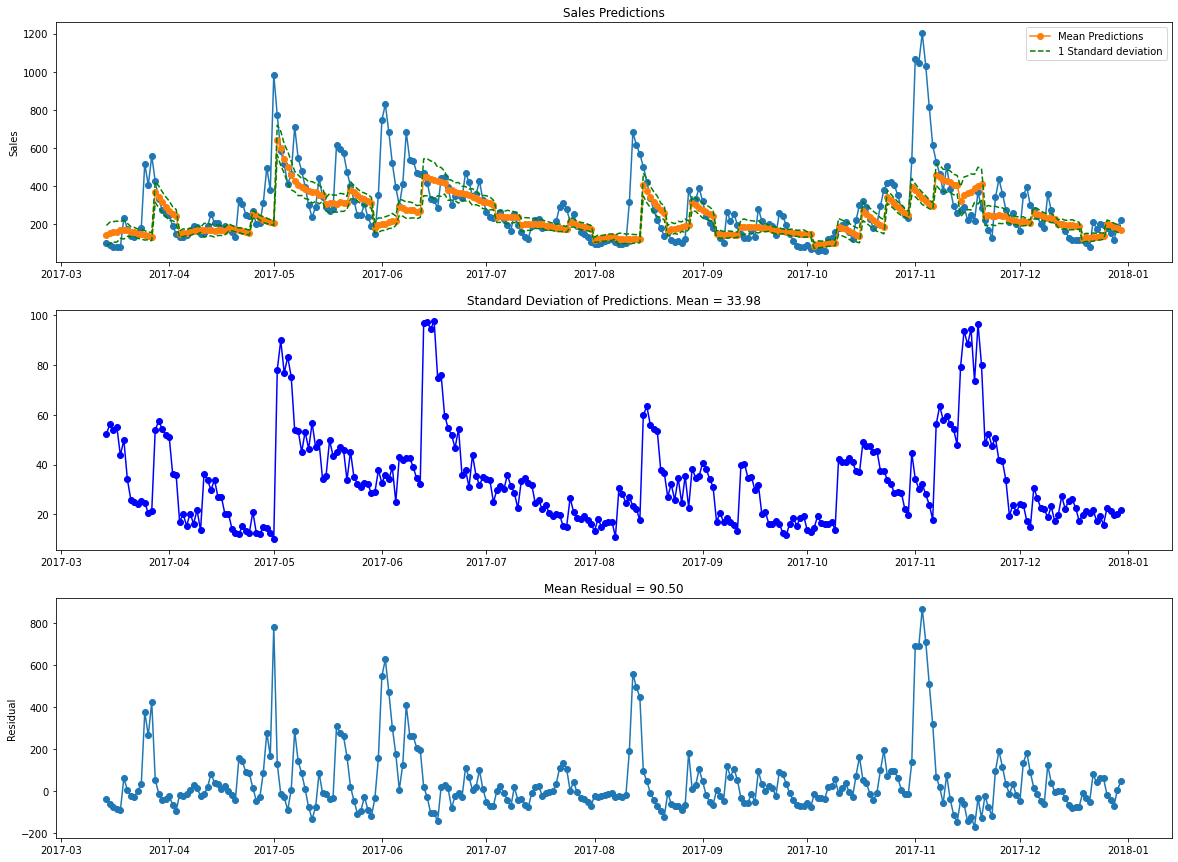

In [58]:
plot_results(test["Sales"],LSTM_mean_pred,LSTM_std)

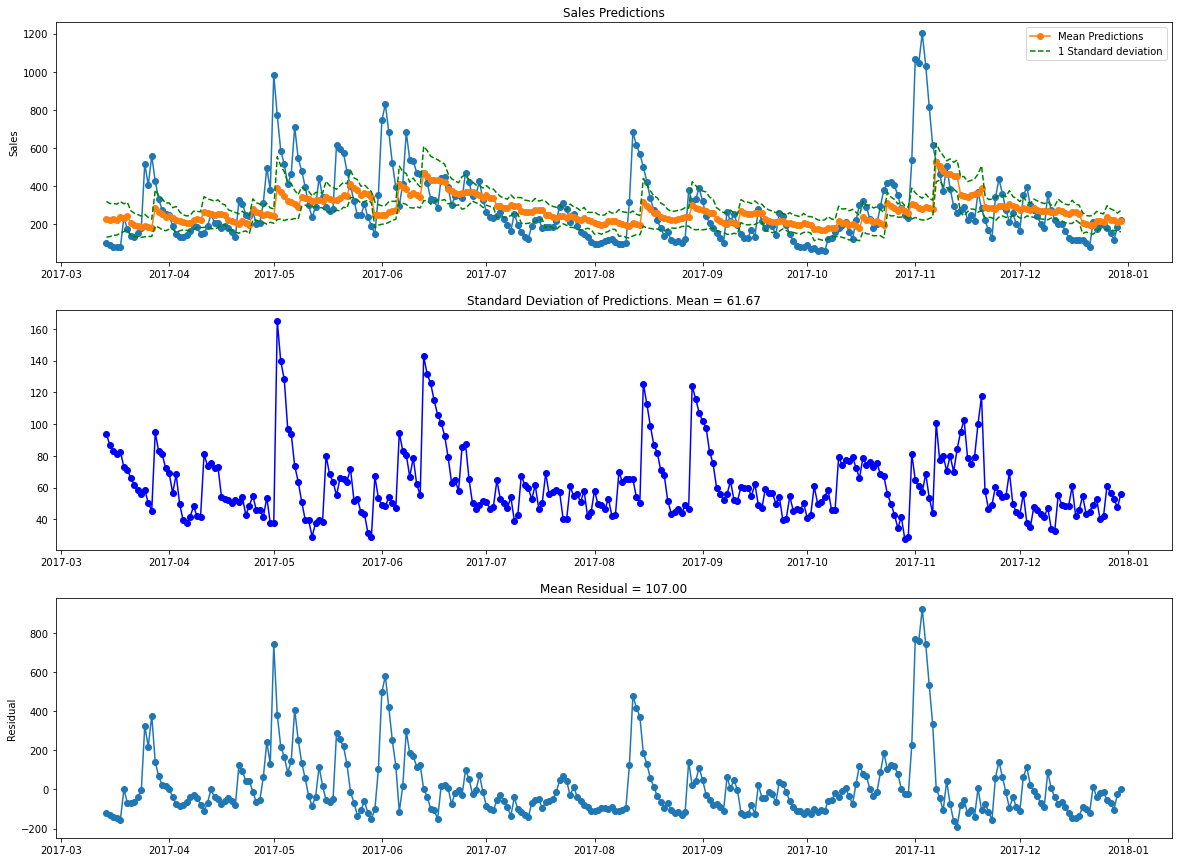

In [59]:
plot_results(test["Sales"],Stacked_LSTM_mean_pred,Stacked_LSTM_std)